In [1]:
% matplotlib inline
import pandas as pd
import datetime
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import numpy as np
import seaborn
import re
from operator import add
from collections import defaultdict
import cPickle as pk

START = '1/1/2011'
END = '7/31/2016'


## CHANGE THESE
# location of pickle file
data_file = '../datasets/mta.pk'
# location of Excel from MTA website.
info_file = '../datasets/Remote-Booth-Station.xls'
# location to output processed dataframe
output_file = '../datasets/processed.pk'

upper_lim = 0.95

with open(data_file,'rb') as f:
    data = pk.load(f)

info = pd.read_excel(info_file)

def key_to_station(key,info=info):
    booth,remote = key.split('_')[:2]
    results = info[['Station','Line Name']][(info.Booth == booth) & (info.Remote == remote)].apply(lambda t: tuple(t), axis = 1)
    if len(results) == 0:
        return (None,None)
    else:
        return results.values[0]

orig_keys = list(data.keys())

stations = defaultdict(list)

print('Total %d dataframes.' % len(orig_keys))
for i,key in enumerate(orig_keys):
    if not i % 500:
        print(i,key)
    station,line = key_to_station(key)
    if station is None:
        #print('Deleting %s' % key)
        del data[key]
        continue
    stations[(station,line)].append(key)
    data[key] = data[key].diff()
    data[key].entries.fillna(0,inplace=True)
    data[key].exits.fillna(0,inplace=True)
    quantiles = data[key].quantile(upper_lim)
    data[key].entries[data[key].entries < 0] = 0
    data[key].exits[data[key].exits < 0] = 0
    data[key].entries[data[key].entries > quantiles['entries']] = quantiles['entries']
    data[key].exits[data[key].exits > quantiles['exits']] = quantiles['exits']
print(len(orig_keys) - len(data))

df_by_station = {}
for station in stations:
    df = reduce(add,
                [data[key] for key in stations[station]])
    df_by_station[station] = df

station_panel = pd.Panel.from_dict(df_by_station).transpose(2,1,0)

final_df = station_panel.entries + station_panel.exits

# remove initial row (all 0)
final_df = final_df[START:END]

final_df.to_pickle(output_file)

Total 4947 dataframes.
(0, '55_R508_00-00-00')
(500, 'C003_R089_00-00-00')
(1000, 'JFK03_R536_00-03-04')
(1500, 'N102_R127_01-00-02')
(2000, 'N324_R018_00-03-01')
(2500, 'N534_R220_01-00-02')
(3000, 'PTH20_R549_03-01-00')
(3500, 'R182_R035_00-03-00')
(4000, 'R258_R132_00-06-02')
(4500, 'R523_R147_00-05-01')
150


In [2]:
def agg_plot(df,agg='mean',timescale='M',time_agg=np.sum):
    # final_df.mean(axis=1).groupby(
    #      pd.TimeGrouper('M')).agg(np.sum).plot()
    df.__getattr__(agg)(axis=1).groupby(pd.TimeGrouper(timescale)).agg(time_agg).plot()

def get_top_n(df,n=100,agg='mean'):
    tmp = df.__getattr__(agg)(axis=0)
    tmp.sort_values(inplace=True,ascending=False)
    return tmp.head(n)

def resample_data(df,timescale='M',time_agg=np.sum):
    # final_df.mean(axis=1).groupby(
    #      pd.TimeGrouper('M')).agg(np.sum).plot()
    return df.groupby(pd.TimeGrouper(timescale)).agg(time_agg)

def make_pretty_plot(df,fig = None,ax = None,figsize=(12,6),timescale='M',err_style='ci_band',**kwargs):
    # n_boot=500
    if ax is None:
        fig,ax = plt.subplots(figsize=figsize)
    if ax is not None and fig is None:
        fig = ax.get_figure()
    agg_df = resample_data(df,timescale=timescale)
    data = [_[1] for _ in agg_df.iteritems()]
    time = [mdates.date2num(pd.Timestamp(_).to_pydatetime()) for _ in data[0].index]
    seaborn.tsplot(data=data,time=time,err_style=err_style,ax=ax,**kwargs)
    # assign locator and formatter for the xaxis ticks.
    ax.xaxis.set_major_locator(mdates.AutoDateLocator())
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y.%m.%d'))

    # put the labels at 45deg since they tend to be too long
    fig.autofmt_xdate()
    return ax


def make_pivot_table(df,timescale='weekday',**kwargs):
    df_copy = df.copy()
    df_copy[timescale] = df_copy.index.__getattribute__(timescale)
    output = df_copy.pivot_table(index=timescale,**kwargs)
    return output

def pivot_plot(df,timescale='weekday',agg='mean',xticklabels=None,xticks=None,**kwargs):
    pivot = make_pivot_table(df,timescale=timescale)
    ax = pivot.__getattr__(agg)(axis=1).plot()
    ax.set_ylabel('Traffic (millions)', fontdict = {'fontsize': 18}, labelpad = 20)
    ax.set_title('Average Total Traffic by %s' % timescale.capitalize(), fontdict = {'fontsize': 24})
    if xticks is not None:
        ax.set_xticks(xticks)
    if xticklabels is not None:
        ax.set_xticklabels(xticklabels)
    ax.xaxis.labelpad = 20
    for item in ([ax.xaxis.label, ax.yaxis.label]):
        item.set_fontsize(18)

    for item in (ax.get_xticklabels() + ax.get_yticklabels()):
        item.set_fontsize(14)

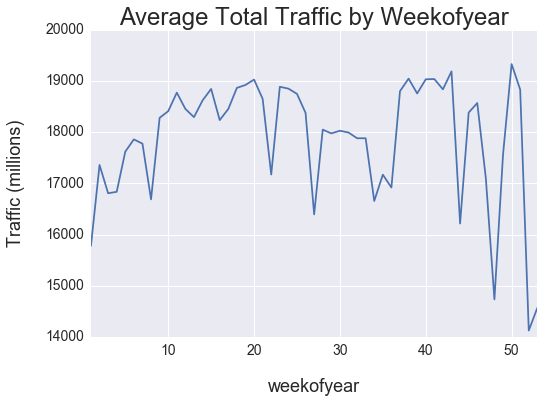

In [3]:
pivot_plot(final_df,'weekofyear')

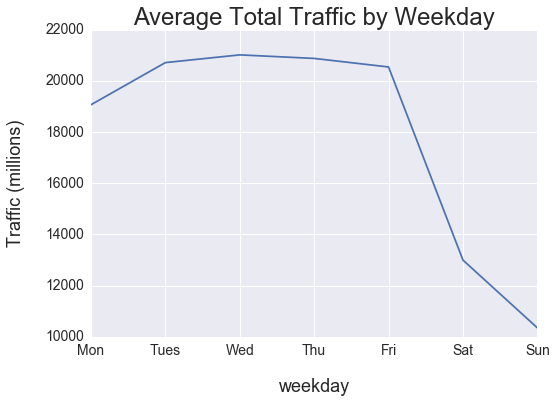

In [4]:
pivot_plot(final_df,'weekday',xticklabels=['Mon','Tues','Wed','Thu','Fri','Sat','Sun'])

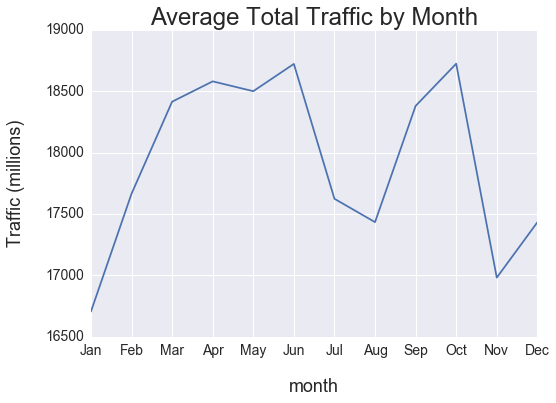

In [5]:
pivot_plot(final_df,'month',xticks=range(1,13),xticklabels=['Jan','Feb','Mar','Apr','May','Jun','Jul','Aug','Sep','Oct','Nov','Dec'])

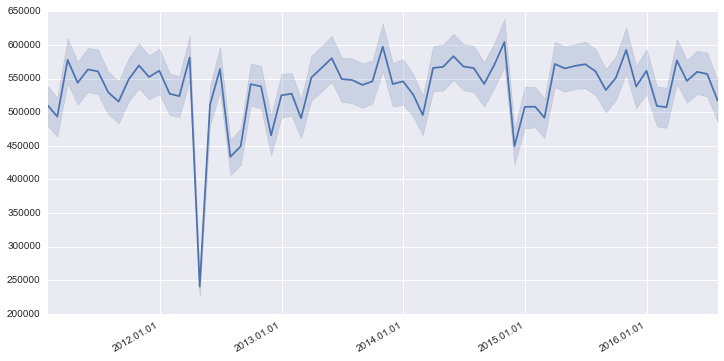

In [6]:
make_pretty_plot(final_df,timescale='M')

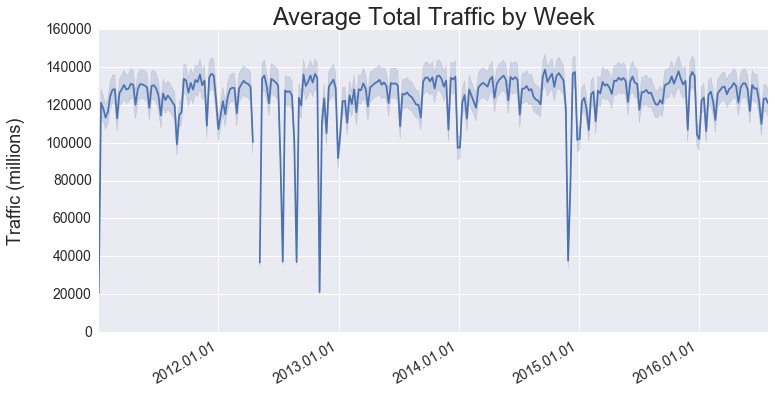

In [7]:
ax = make_pretty_plot(final_df,timescale='W')


ax.set_ylabel('Traffic (millions)', fontdict = {'fontsize': 18}, labelpad = 20)
ax.set_title('Average Total Traffic by Week', fontdict = {'fontsize': 24})

ax.xaxis.labelpad = 20
for item in ([ax.xaxis.label, ax.yaxis.label]):
    item.set_fontsize(18)

for item in (ax.get_xticklabels() + ax.get_yticklabels()):
    item.set_fontsize(14)



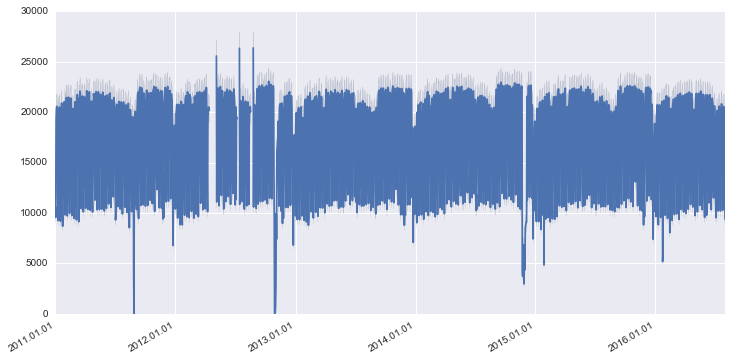

In [8]:
make_pretty_plot(final_df,timescale='D')

ax.set_ylabel('Traffic (millions)', fontdict = {'fontsize': 18}, labelpad = 20)
ax.set_title('Total Traffic by Day', fontdict = {'fontsize': 24})

ax.xaxis.labelpad = 20
for item in ([ax.xaxis.label, ax.yaxis.label]):
    item.set_fontsize(18)

for item in (ax.get_xticklabels() + ax.get_yticklabels()):
    item.set_fontsize(14)

